In [1]:
import os, sys
print("CWD:", os.getcwd())
print("sys.path[0]:", sys.path[0])

CWD: /workspaces/COMP560FinalProject/notebooks
sys.path[0]: /workspaces/COMP560FinalProject/notebooks


In [2]:
import os, sys

# Go up one directory from notebooks/ to the project root
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

print("Added to sys.path:", PROJECT_ROOT)

Added to sys.path: /workspaces/COMP560FinalProject


In [8]:
from src.model import load_raw_data, add_targets, run_regression_models, FEATURE_COLUMNS, compare_regression_feature_sets
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = load_raw_data("../data/merged.csv")
df = add_targets(df)

len(df), df[FEATURE_COLUMNS].shape[1]


(1773, 14)

In [5]:
results_reg = run_regression_models(
    df,
    models=["linear", "ridge", "sgd"],
)

for name, res in results_reg.items():
    print(f"{name:8s}  MSE = {res.mse:,.2f}   R² = {res.r2:.3f}")


linear    MSE = 213,996,378,857,026,543,943,680.00   R² = 0.465
ridge     MSE = 250,176,285,173,405,513,154,560.00   R² = 0.375
sgd       MSE = 303,676,066,709,514,057,940,992.00   R² = 0.241


In [ ]:
from src.model import make_regression_pipeline, train_test_split_all

X_train, X_test, y_train, y_test, _, _ = train_test_split_all(df)
pipe = make_regression_pipeline("linear")
pipe.fit(X_train, y_train)

scaler = pipe.named_steps["scaler"]
model = pipe.named_steps["model"]

coef = model.coef_
feature_importance = sorted(zip(FEATURE_COLUMNS, coef), key=lambda x: abs(x[1]), reverse=True)

for name, c in feature_importance[:15]:
    print(f"{name:35s} {c: .4f}")


Air pollution                       -96954060722472.9375
Outdoor air pollution                50059064103521.5312
Household air pollution from solid fuels  46470489691906.3438
Unsafe water source                 -2348018667265.9600
Child wasting                        2212374885168.0977
Low bone mineral density             1793162725910.5410
High systolic blood pressure         1711052827709.3293
Child stunting                       1373089837238.6680
Vitamin A deficiency                -1292781336656.9648
Secondhand smoke                    -1278416289911.3464
Iron deficiency                      1051277049924.0188
High fasting plasma glucose          1029746007899.4073
High body-mass index                -384499222505.9152
Low birth weight for gestation       15113961510.0795


In [ ]:
import json
from src.model import (
    run_regression_models,
    run_classification_models,
    FEATURE_COLUMNS,
    make_regression_pipeline,
    train_test_split_all,
)

df = load_raw_data("../data/merged.csv")
df = add_targets(df)

reg_results = run_regression_models(df)
clf_results = run_classification_models(df)

# Get top coefficients from one model for interpretability
X_train, X_test, y_train, y_test, _, _ = train_test_split_all(df)
pipe = make_regression_pipeline("linear")
pipe.fit(X_train, y_train)
model = pipe.named_steps["model"]

coef = model.coef_
feature_importance = sorted(
    zip(FEATURE_COLUMNS, coef),
    key=lambda x: abs(x[1]),
    reverse=True,
)

top_features = feature_importance[:10]

summary_data = {
    "n_rows": int(df.shape[0]),
    "n_features": len(FEATURE_COLUMNS),
    "regression_results": {k: vars(v) for k, v in reg_results.items()},
    "classification_results": {k: vars(v) for k, v in clf_results.items()},
    "top_features": [
        {"name": name, "coef": float(c)} for name, c in top_features
    ],
}

print(json.dumps(summary_data, indent=2))

{
  "n_rows": 1773,
  "n_features": 14,
  "regression_results": {
    "linear": {
      "model_name": "linear",
      "mse": 2.1399637885702654e+23,
      "r2": 0.46504092095342964
    },
    "sgd": {
      "model_name": "sgd",
      "mse": 2.918846558047819e+23,
      "r2": 0.2703318276171651
    }
  },
  "classification_results": {
    "logreg_gd": {
      "model_name": "logreg_gd",
      "accuracy": 0.8309859154929577,
      "f1": 0.8429319371727748
    },
    "logreg_liblinear": {
      "model_name": "logreg_liblinear",
      "accuracy": 0.847887323943662,
      "f1": 0.859375
    }
  },
  "top_features": [
    {
      "name": "Air pollution",
      "coef": -96954060722472.94
    },
    {
      "name": "Outdoor air pollution",
      "coef": 50059064103521.53
    },
    {
      "name": "Household air pollution from solid fuels",
      "coef": 46470489691906.34
    },
    {
      "name": "Unsafe water source",
      "coef": -2348018667265.96
    },
    {
      "name": "Child wasting"

In [6]:
reg_comparison = compare_regression_feature_sets(df)
reg_comparison

,feature_set,model,mse,r2
0,all,linear,2.139964e+23,0.465041
1,all,sgd,3.036761e+23,0.240855
2,clinical,linear,3.038705e+23,0.240369
3,clinical,sgd,3.184381e+23,0.203952
4,environmental,linear,3.452849e+23,0.136839
5,environmental,sgd,3.443445e+23,0.139190


In [10]:
# Run all regression models
reg_results = run_regression_models(
    df,
    models=["linear", "ridge", "sgd"],
)

# Convert to DataFrame for plotting
reg_df = pd.DataFrame([
    {
        "model": name,
        "MSE": res.mse,
        "R2": res.r2,
    }
    for name, res in reg_results.items()
])

reg_df

,model,MSE,R2
0,linear,2.139964e+23,0.465041
1,ridge,2.501763e+23,0.374597
2,sgd,3.036761e+23,0.240855


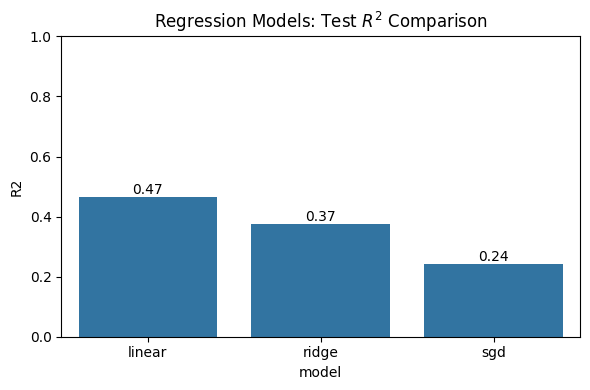

In [14]:
plt.figure(figsize=(6, 4))
sns.barplot(
    data=reg_df.sort_values("R2", ascending=False),
    x="model",
    y="R2",
)
plt.title("Regression Models: Test $R^2$ Comparison")
plt.ylim(0, 1) 
for i, row in reg_df.sort_values("R2", ascending=False).reset_index().iterrows():
    plt.text(i, row["R2"] + 0.01, f"{row['R2']:.2f}", ha="center")
plt.tight_layout()
plt.show()

In [18]:
import json
from pathlib import Path

# Convert RegressionResult dataclasses -> plain dicts
reg_results_dict = {
    name: {
        "model_name": res.model_name,
        "mse": float(res.mse),
        "r2": float(res.r2),
    }
    for name, res in reg_results.items()
}


# reg_feature_dict = reg_feature_df.to_dict(orient="records")

output_dir = Path(PROJECT_ROOT) / "AI"
output_dir.mkdir(exist_ok=True)

with open(output_dir / "regression_results.json", "w") as f:
    json.dump(reg_results_dict, f, indent=2)

print("Saved regression results to", output_dir / "regression_results.json")

Saved regression results to /workspaces/COMP560FinalProject/AI/regression_results.json
